<a href="https://colab.research.google.com/github/Rithika-Shankar/Titanic-Survival-Prediction/blob/main/titanic_survival_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from xgboost import XGBClassifier


In [123]:
df = pd.read_csv('tested.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [124]:
def process_features(data):
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                           'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    data['AgeBin'] = pd.cut(data['Age'].fillna(data['Age'].median()),
                            bins=[0, 12, 20, 40, 60, 120],
                            labels=['Child', 'Teen', 'Adult', 'MiddleAge', 'Senior'])

    data['FareBin'] = pd.qcut(data['Fare'], 5, labels=[1, 2, 3, 4, 5])

    data['HasCabin'] = data['Cabin'].notna().astype(int)
    data['Deck'] = data['Cabin'].str[0].fillna('Unknown')

    data['TicketPrefix'] = data['Ticket'].str.split().str[0].str.replace('.', '').str.replace('/', '')
    data['TicketPrefix'] = data['TicketPrefix'].where(data['TicketPrefix'].str.isalpha(), 'None')

    data['TicketNumber'] = data['Ticket'].str.extract('(\d{2,})', expand=False)
    data['TicketNumber'] = pd.to_numeric(data['TicketNumber'])
    data['TicketNumber'].fillna(data['TicketNumber'].median(), inplace=True)

    return data

df = process_features(df)


In [125]:
def build_preprocessor():
    num_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'TicketNumber']
    cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'IsAlone', 'HasCabin']

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    return preprocessor


In [126]:
X = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocessor = build_preprocessor()

In [127]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", round(accuracy_score(y_test, preds), 4))
    print("Precision:", round(precision_score(y_test, preds), 4))
    print("Recall:", round(recall_score(y_test, preds), 4))
    print("F1 Score:", round(f1_score(y_test, preds), 4))
    print("ROC AUC:", round(roc_auc_score(y_test, probas), 4))

    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [128]:
def show_feature_importance(pipeline, X):

    model = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']

    numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'TicketNumber']
    categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'IsAlone', 'HasCabin']

    preprocessor.fit(X)
    ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = numeric_features + list(ohe_features)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("This model does not support feature importance.")
        return

    if len(importances) != len(all_features):
        print("Mismatch between number of features and importances.")
        return


Evaluating Random Forest...
Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



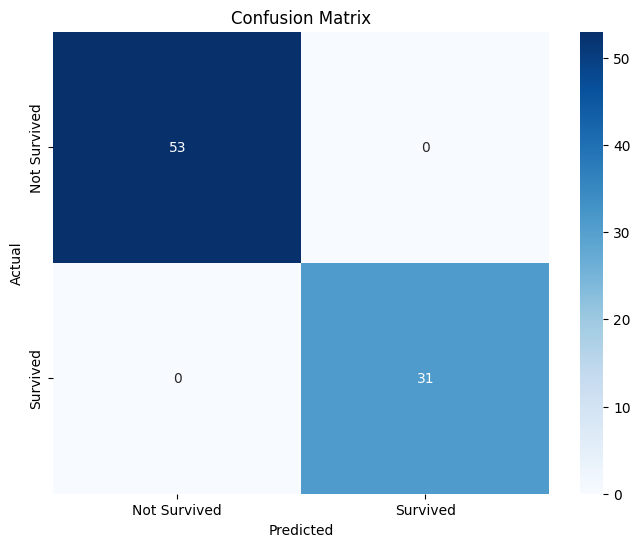

Mismatch between number of features and importances.

Evaluating Gradient Boosting...
Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



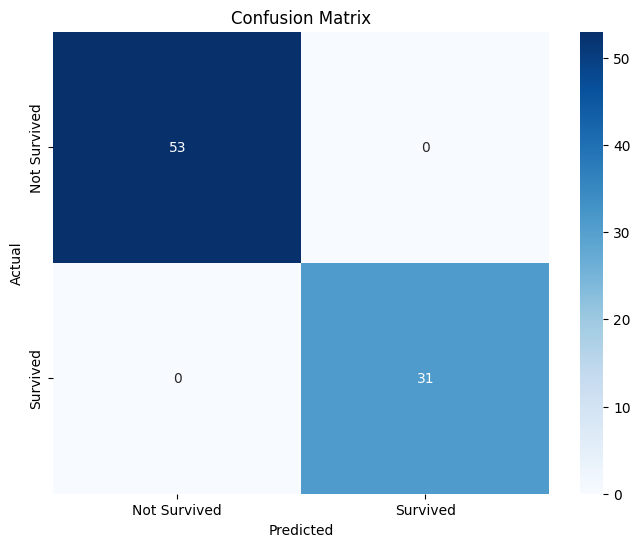

Mismatch between number of features and importances.

Evaluating XGBoost...
Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



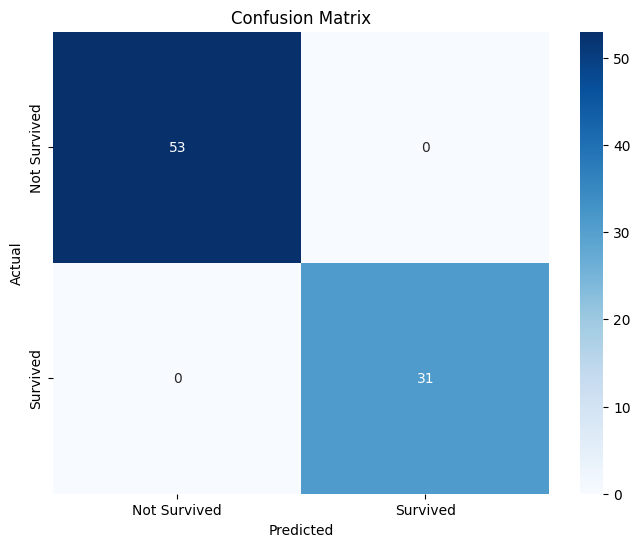

Mismatch between number of features and importances.

Evaluating Logistic Regression...
Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



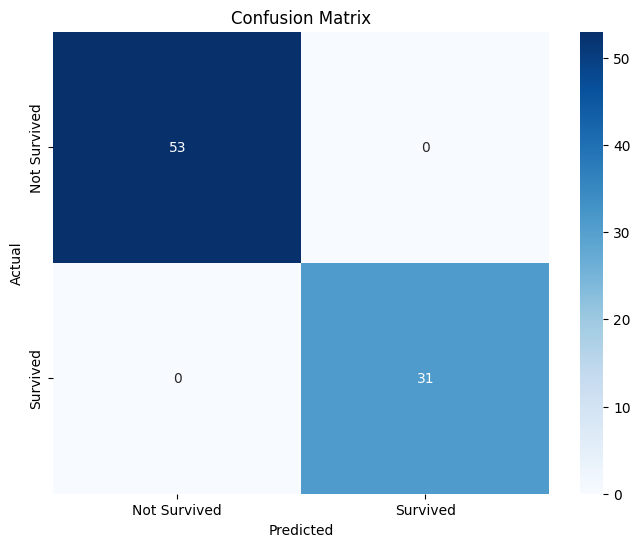


Evaluating SVM...
Model Evaluation Metrics:
Accuracy: 0.9881
Precision: 1.0000
Recall: 0.9677
F1 Score: 0.9836
ROC AUC: 0.9994

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.97      0.98        31

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.99        84
weighted avg       0.99      0.99      0.99        84



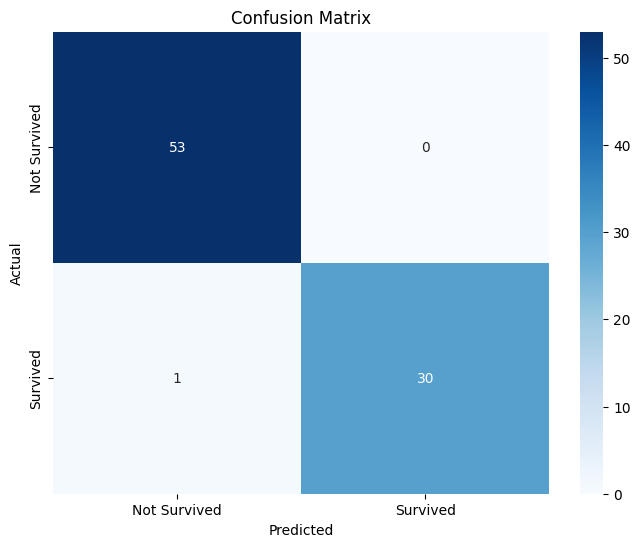

In [129]:
from collections import defaultdict

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True)
}

results = defaultdict(dict)

for name, model in models.items():
    print(f"\nEvaluating {name}...")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(f_classif, k=20)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    metrics = evaluate_model(pipeline, X_test, y_test)
    results[name] = metrics

    if name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
        show_feature_importance(pipeline, X_train)


    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    results[name]['CV Mean Acc'] = scores.mean()
    results[name]['CV Std'] = scores.std()



In [130]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

    results.append({
        "Model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        "CV Mean Acc": np.mean(cv_scores),
        "CV Std": np.std(cv_scores)
    })

results_df = pd.DataFrame(results)

In [131]:
results_df.sort_values(by='f1', ascending=False, inplace=True)
print(results_df)

                 Model  accuracy  precision    recall       f1   roc_auc  \
0        Random Forest  1.000000   1.000000  1.000000  1.00000  1.000000   
1    Gradient Boosting  1.000000   1.000000  1.000000  1.00000  1.000000   
2              XGBoost  1.000000   1.000000  1.000000  1.00000  1.000000   
3  Logistic Regression  1.000000   1.000000  1.000000  1.00000  1.000000   
4                  SVM  0.964286   0.966667  0.935484  0.95082  0.998174   

   CV Mean Acc    CV Std  
0     1.000000  0.000000  
1     1.000000  0.000000  
2     1.000000  0.000000  
3     1.000000  0.000000  
4     0.967074  0.030434  


In [132]:
best_accuracy_model = results_df.loc[results_df['accuracy'].idxmax()]
best_precision_model = results_df.loc[results_df['precision'].idxmax()]
best_recall_model = results_df.loc[results_df['recall'].idxmax()]
best_f1_model = results_df.loc[results_df['f1'].idxmax()]
best_roc_auc_model = results_df.loc[results_df['roc_auc'].idxmax()]

best_models = [
    best_accuracy_model['Model'],
    best_precision_model['Model'],
    best_recall_model['Model'],
    best_f1_model['Model'],
    best_roc_auc_model['Model']
]

best_model_counts = pd.Series(best_models).value_counts()

most_frequent_best_model = best_model_counts.idxmax()

print(f"\nThe selected best model based on the majority of metrics is: {most_frequent_best_model}")


The selected best model based on the majority of metrics is: Random Forest
